#  CLAHE 보정 기반 LED 타워램프 분류

크롭된 LED 이미지를 CLAHE로 보정한 후 머신러닝 분류 성능을 실험합니다.

## 라이브러리 불러오기

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm

## CLAHE (밝기 대비 향상) 전처리 함수

In [22]:
def preprocess_clahe(img):
    img = cv2.resize(img, (100, 100))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

## Feature 추출 함수

In [23]:
def extract_features(image):
    img = preprocess_clahe(image)  # CLAHE 적용
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    avg_brightness = np.mean(gray)
    max_brightness = np.max(gray)
    std_brightness = np.std(gray)

    avg_b, avg_g, avg_r = cv2.mean(img)[:3]

    def mask_ratio(hsv_img, lower, upper):
        mask = cv2.inRange(hsv_img, lower, upper)
        return np.count_nonzero(mask) / (mask.size + 1e-6)

    green_ratio = mask_ratio(hsv, (40, 50, 50), (85, 255, 255))
    yellow_ratio = mask_ratio(hsv, (20, 50, 50), (35, 255, 255))
    red_ratio = (
        mask_ratio(hsv, (0, 50, 50), (10, 255, 255)) +
        mask_ratio(hsv, (160, 50, 50), (180, 255, 255))
    )

    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.count_nonzero(edges)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_area = sum(cv2.contourArea(c) for c in contours)

    hue_mean = np.mean(hsv[:, :, 0])
    saturation_mean = np.mean(hsv[:, :, 1])
    value_mean = np.mean(hsv[:, :, 2])

    return [
        avg_brightness, max_brightness, std_brightness,
        avg_r, avg_g, avg_b,
        green_ratio, yellow_ratio, red_ratio,
        edge_count, contour_area,
        hue_mean, saturation_mean, value_mean
    ]

## 보정 전/후 샘플 시각화

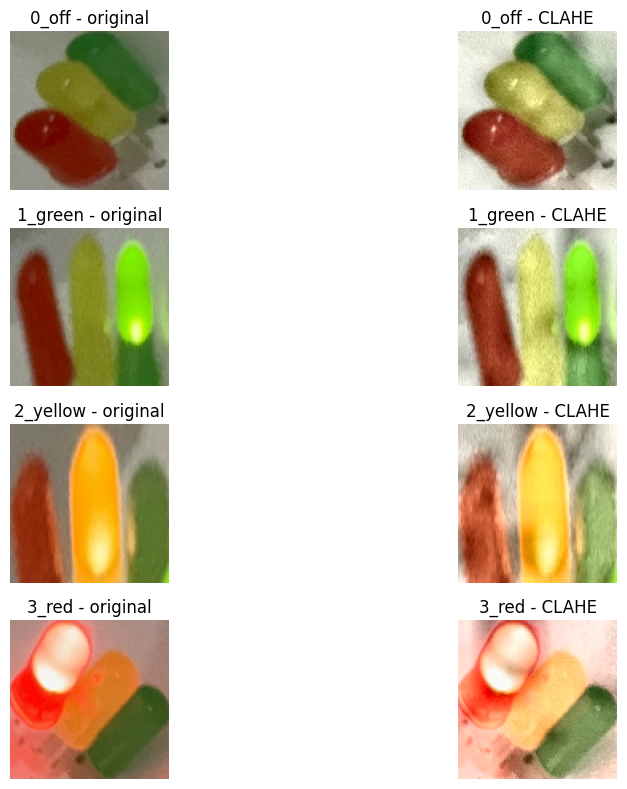

In [24]:
label_map = {
    '0_off': 0,
    '1_green': 1,
    '2_yellow': 2,
    '3_red': 3
}
data_dir = r'C:\Users\tori\Documents\vision 2nd project\openCV\rabel'

plt.figure(figsize=(12, 8))
for i, (folder, label) in enumerate(label_map.items()):
    folder_path = os.path.join(data_dir, folder)
    sample_img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = cv2.imread(sample_img_path)
    img_rgb = cv2.cvtColor(cv2.resize(img, (100, 100)), cv2.COLOR_BGR2RGB)
    img_clahe = cv2.cvtColor(preprocess_clahe(img), cv2.COLOR_BGR2RGB)

    plt.subplot(4, 2, i*2 + 1)
    plt.imshow(img_rgb)
    plt.title(f"{folder} - original")
    plt.axis('off')

    plt.subplot(4, 2, i*2 + 2)
    plt.imshow(img_clahe)
    plt.title(f"{folder} - CLAHE")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 전체 이미지 처리 및 CSV 저장

In [25]:
rows = []
for label_name in tqdm(os.listdir(data_dir)):
    label_path = os.path.join(data_dir, label_name)
    if not os.path.isdir(label_path) or label_name not in label_map:
        continue
    label = label_map[label_name]

    for fname in os.listdir(label_path):
        fpath = os.path.join(label_path, fname)
        img = cv2.imread(fpath)
        if img is None:
            continue
        features = extract_features(img)
        rows.append(features + [label])

columns = [f'f{i}' for i in range(len(rows[0])-1)] + ['label']
df = pd.DataFrame(rows, columns=columns)
df.to_csv('led_features_CLAHE.csv', index=False)
print(f"✅ 저장 완료: {len(df)}개 샘플")

100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

✅ 저장 완료: 502개 샘플


## 모델 학습 및 성능 평가

In [31]:
df = pd.read_csv('led_features_CLAHE.csv')
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.87      0.97      0.92        34
           2       0.91      0.83      0.87        12
           3       1.00      1.00      1.00         5

    accuracy                           0.94       101
   macro avg       0.94      0.94      0.94       101
weighted avg       0.94      0.94      0.94       101



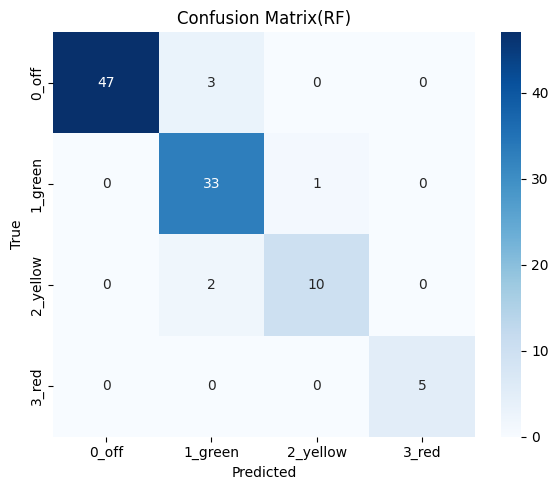

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 클래스 이름 설정 (라벨 숫자 → 의미 부여)
labels = ['0_off', '1_green', '2_yellow', '3_red']

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix(RF)')
plt.tight_layout()
plt.show()



In [27]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


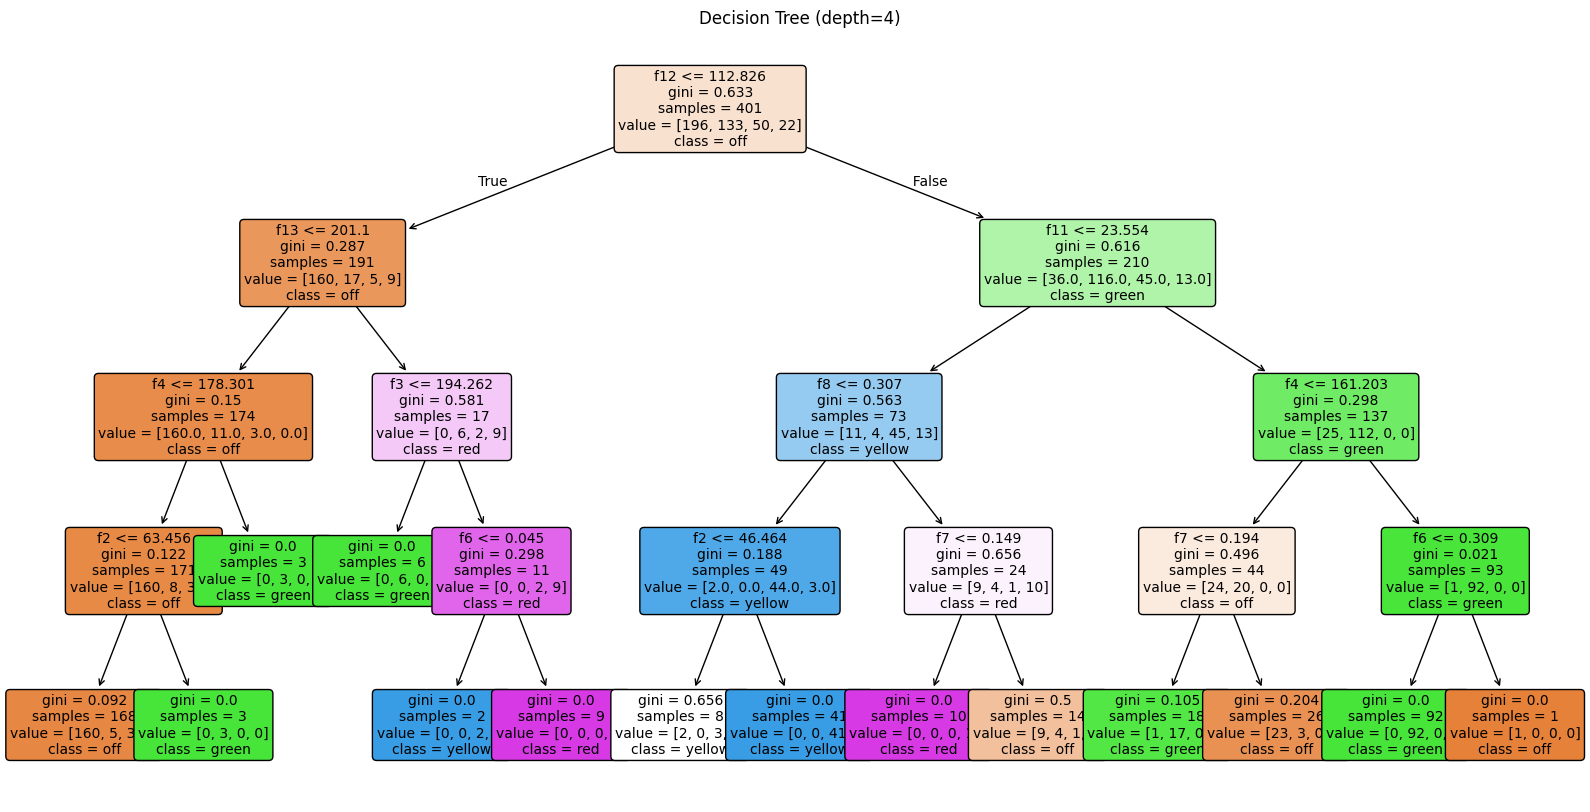

In [28]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=['off', 'green', 'yellow', 'red'], 
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree (depth=4)")
plt.show()

In [29]:
# f0 ~ f13용 설명 딕셔너리 만들기
feature_descriptions = {
    'f0': 'Grayscale 평균 밝기',
    'f1': 'Grayscale 최대 밝기',
    'f2': 'Grayscale 표준편차',
    'f3': 'R 채널 평균',
    'f4': 'G 채널 평균',
    'f5': 'B 채널 평균',
    'f6': 'green mask 비율',
    'f7': 'yellow mask 비율',
    'f8': 'red mask 비율',
    'f9': 'edge 픽셀 수',
    'f10': 'contour 총 면적',
    'f11': 'HSV hue 평균',
    'f12': 'HSV saturation 평균',
    'f13': 'HSV value 평균'
}


feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances,
    'Description': [feature_descriptions[f] for f in X.columns]
})
feat_imp

,Feature,Importance,Description
0,f0,0.000000,Grayscale 평균 밝기
1,f1,0.000000,Grayscale 최대 밝기
2,f2,0.043072,Grayscale 표준편차
3,f3,0.030211,R 채널 평균
4,f4,0.102111,G 채널 평균
5,f5,0.000000,B 채널 평균
6,f6,0.024002,green mask 비율
7,f7,0.106826,yellow mask 비율
8,f8,0.073562,red mask 비율
9,f9,0.000000,edge 픽셀 수


In [30]:
import pandas as pd
importances = tree_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
feat_imp

,Feature,Importance
12,f12,0.317395
11,f11,0.216472
7,f7,0.106826
4,f4,0.102111
13,f13,0.086349
8,f8,0.073562
2,f2,0.043072
3,f3,0.030211
6,f6,0.024002
0,f0,0.000000


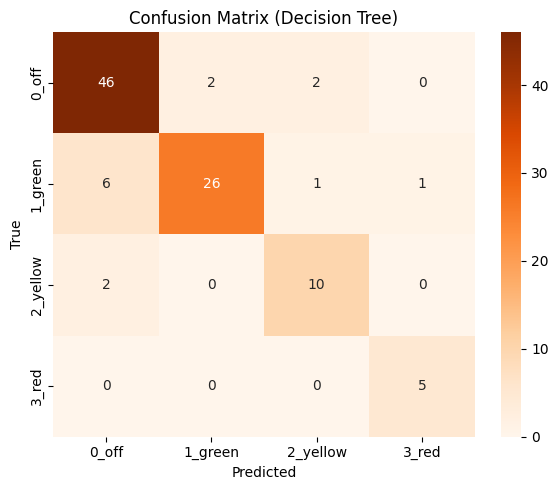

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측값 생성
y_pred_tree = tree_model.predict(X_test)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred_tree)

# 시각화
labels = ['0_off', '1_green', '2_yellow', '3_red']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Decision Tree)')
plt.tight_layout()
plt.show()
